In [1]:
import pandas as pd
import numpy as np
from Plotter.aggregation import (
    RowFigureConcatenationReport,
    ColumnFigureConcatenationReport,
)
from Plotter.text import TitleReport

from Plotter.line import *
from Plotter.bar import *
from Plotter.table import *
import datetime

import empyrical as ep

In [2]:
best_dict = {"ES=F": [20, 1, 4], "YM=F": [24], "NQ=F": [22, 8, 23],
             "EUR=X": [3], "JPY=X": [19], "GBP=X": [12], "BRL=X": [8], "MXN=X": [13], "CAD=X": [21],
             "GC=F": [8],
             "ZF=F": [19], "ZT=F": [0], "ZB=F": [4], "ZN=F": [13]
            }

name_dict ={
    "ES=F": "MiniESF",  "YM=F": "YM", "NQ=F": "NQ",
    "EUR=X": "Euro", "JPY=X": "JPY", "GBP=X": "Libra", "BRL=X": "BRL", "MXN=X": "MXN", "CAD=X": "CAD",
    "GC=F": "Gold",
    "ZF=F": "ZF", "ZT=F": "ZT", "ZB=F": "ZB", "ZN=F": "ZN"
}
tickers=[
      'ZF=F', 'ZT=F', 'ZB=F', "ZN=F",
      "ES=F", "YM=F", "NQ=F", "RTY=F",
      "GC=F", "SI=F", "ZC=F", "CL=F", "SB=F", "CT=F",
      "EUR=X", "JPY=X", "GBP=X", 'BRL=X', "MXN=X", "CAD=X"
  ]
for ticker in tickers:
    try:
        name = name_dict[ticker]
        test = pd.read_pickle(f"TFT_Data/{name}Test.pkl") 
        validation = pd.read_pickle(f"TFT_Data/{name}.pkl") 
        best = best_dict[ticker]

        aux = {}
        aux[f"{ticker}"] = validation[0][f"{ticker}"]
        aux[f"{ticker}_Real"] = validation[0][f"{ticker}_Real"]
        aux[f"{ticker}_Date"] = validation[0][f"{ticker}_Date"]
        validation_output = pd.DataFrame(aux).set_index(f"{ticker}_Date")
        validation_output[f"{ticker}"] = validation_output[f"{ticker}"]*0

        aux = {}
        aux[f"{ticker}"] = test[0][f"{ticker}"]
        aux[f"{ticker}_Real"] = test[0][f"{ticker}_Real"]
        aux[f"{ticker}_Date"] = test[0][f"{ticker}_Date"]
        test_output = pd.DataFrame(aux).set_index(f"{ticker}_Date")
        test_output[f"{ticker}"] = test_output[f"{ticker}"]*0

        # best = best[-3:]
        for k in best:
            validation_output[f"{ticker}"] = validation_output[f"{ticker}"] + validation[k][f"{ticker}"]

        validation_output[f'{ticker}'] = validation_output[f'{ticker}']/len(best)

        for k in best:
            test_output[f"{ticker}"] = test_output[f"{ticker}"] + test[k][f"{ticker}"]

        test_output[f'{ticker}'] = test_output[f'{ticker}']/len(best)

        test_output = pd.concat([validation_output, test_output], axis=0)

        test_output[f"{ticker}_Real"] = np.exp(test_output[f"{ticker}_Real"])-1
        test_output[f"{ticker}"] = np.exp(test_output[f"{ticker}"])-1
        win_rate_list = np.sign(test_output[f"{ticker}"]) == np.sign(test_output[f"{ticker}_Real"])
        test_output["Returns"] = np.sign(test_output[f"{ticker}"]) * test_output[f"{ticker}_Real"]
        test_output.index.rename('date', inplace=True)
        test_output.index = pd.to_datetime(test_output.index)
        signs = np.sign(test_output[f"{ticker}"])
        test_output.rename(columns={f'{ticker}_Real':f'{ticker} Long Only', 'Returns': f"{ticker} Using TFT"}, inplace=True)
        test_output.drop(f"{ticker}", axis=1, inplace=True)
        test_output.to_csv(f"Results/{ticker}.csv")
    except:
        continue

In [3]:


full_returns = test_output[[F'{ticker} Long Only', f"{ticker} Using TFT"]].melt(ignore_index=False, var_name='asset', value_name='Return').reset_index().groupby(['date', 'asset']).sum()['Return']

In [4]:
signs.value_counts()

-1.0    1501
 1.0     140
Name: CAD=X, dtype: int64

In [5]:
win_rate_list.value_counts()

False    836
True     805
dtype: int64

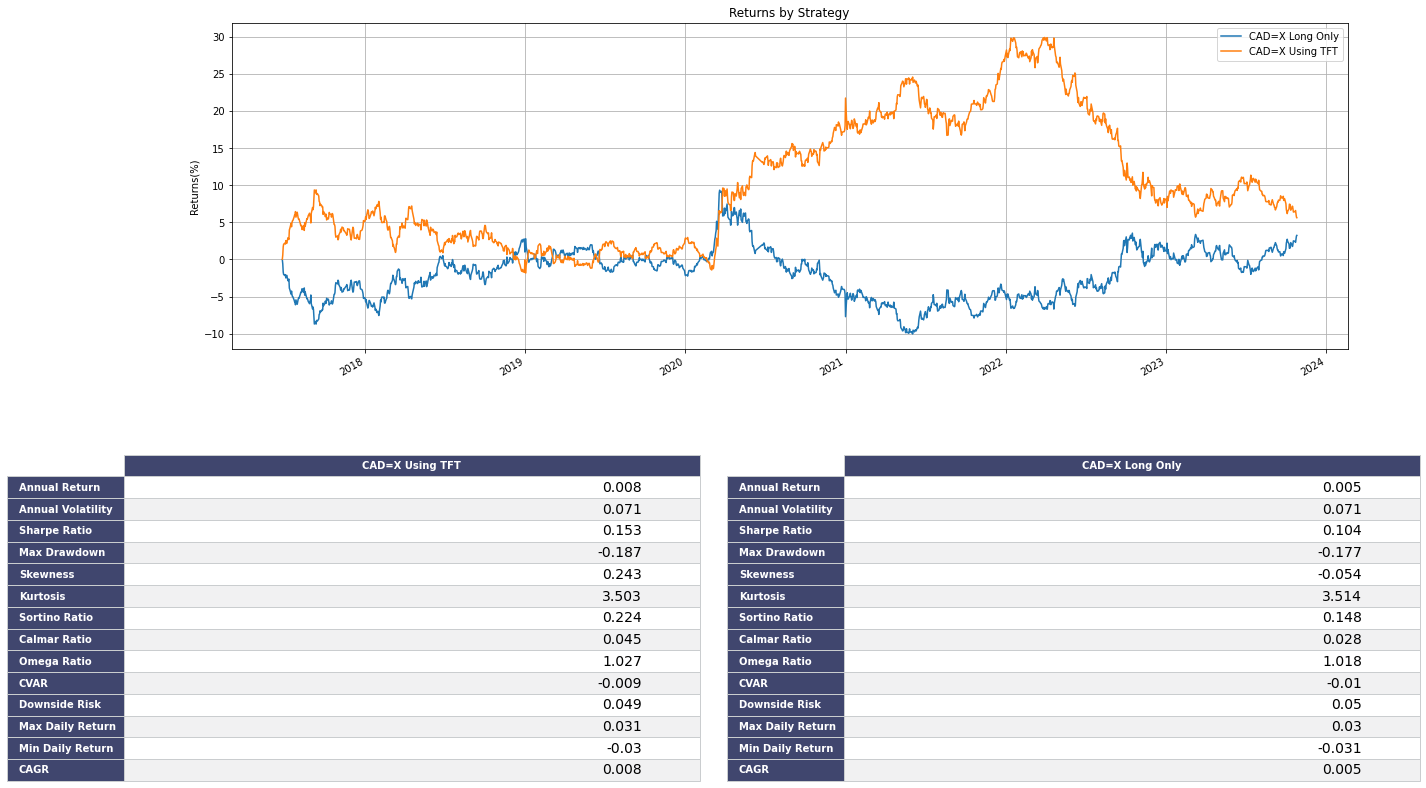

In [6]:
line_returns = CumulativeReturnsWithBenchmarks.from_returns(full_returns, title='Returns by Strategy', ylabel='Returns(%)', figsize=(20, 6))
r1 = ReturnMetricsTable.from_returns(test_output[f"{ticker} Using TFT"], font_size=10, num_font_size=14, vertical=True, figsize=(3, 6), use_index=True, name=f"{ticker} Using TFT")
r2 = ReturnMetricsTable.from_returns(test_output[f'{ticker} Long Only'], font_size=10, num_font_size=14, vertical=True, figsize=(3, 6), use_index=True, name=f'{ticker} Long Only')
row2 = ColumnFigureConcatenationReport.from_report_list([r1, r2], padding=0.1)
RowFigureConcatenationReport.from_report_list([line_returns, row2]).plot()